In [245]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as rnd
import random
import math
import copy
import seaborn as sns

B S Q

# 0. Parameter settings

In [246]:
num_pop = 100
dimension = 30
# size = 10 #(-100<= X <=100 by binary)

qtb_prob = 0.7 #0.7, 0.8, 0.9
copy_prob = 0.9 # 0.7, 0.8, 0.9
surprise_prob = 0.01 # 0.01, 0.03, 0.05

# 고정
pass_prob = 0.5 # 시작은 0.5~ 점차 +0.1% / 안으로 던질지 밖으로 던질지(고정)
max_pass_prob = 0.9

function_selected = "C03_Rosenbrock" #C03_Rosenbrock #C14_Griewank #C18_expanded_3_14 

win_min = 3
max_iteration = 10000

# 관련 제약식! <<< dimension별로 범위가 다를 때 최대 자릿수를 조정해야함
# power_list = []
# for idx in range(0,dimension):
#     power_list.append(7)
# constraints = []
# for idx in range(0, dimension):
#        constraints.append([-100,100])
       
# print(f'power_list: {power_list}, constraints: {constraints}')

# 1-1. Generate initial solutions

In [247]:
"""
generate_random_solution
: dimension 만큼 하나의 solution 만들기
"""
def generate_random_solution(dimension):
    
    dim = 0
    squad_solution = []
    while dim < dimension:
        
        # -100 ~ 100 사이 추가
        squad_solution.append( (random.random() * 200) - 100 )
        dim = dim + 1
    
    return squad_solution

"""
generate_initial_solutions
: num_pop 만큼 initial solution 만들기
"""

def generate_initial_solutions(num_pop):
    
    pop = 0
    initial_solution = []
    while pop < num_pop:
        
        initial_solution.append(generate_random_solution(dimension))
        pop = pop + 1
    
    return initial_solution

In [248]:
# init_sol = generate_initial_solutions(num_pop)

# for idx in range(0, len(init_sol)):
#     print(f'{idx}: {init_sol[idx]}')

## Function (CEC2017?)

In [249]:
"""
주어진 function(1~29)
: 추후 CEC2017로 교체
: squad(squad_solution) 하나에 대해서!
"""
def C03_Rosenbrock(squad):
    
    #>
    final_sum_term = 0
    for dim in range(0, dimension-1):
        
        final_sum_term = final_sum_term + (100 * ((squad[dim])**2 -  (squad[dim+1]))**2 + (squad[dim] - 1)**2)
    
    return final_sum_term  

def C14_Griewank(squad):
    
    #>
    final_sum_term = 0
    for dim in range(0, dimension):
        final_sum_term = final_sum_term + ((squad[dim])**2)/4000
    
    product_term = 0
    for dim in range(0, dimension):
        product_term = product_term*np.cos((squad[dim])/(dim+1)**(0.5))
    
    return final_sum_term - product_term + 1

def C18_expanded_3_14(squad):
    
    #>
    final_sum_term = 0
    
    #> (1,2) ~ (d-1, d)
    for dim in range(0, dimension-1):
        x = (100 * ((squad[dim])**2 -  (squad[dim+1]))**2 + (squad[dim] - 1)**2)
        final_sum_term = final_sum_term + (x**2)/4000 - np.cos(x) + 1
    
    #> (d, 1)
    x = (100 * ((squad[dimension-1])**2 -  (squad[0]))**2 + (squad[dimension-1] - 1)**2)
    final_sum_term = final_sum_term + (x**2)/4000 - np.cos(x) + 1
    
    return final_sum_term
    
    

In [250]:
"""
function_value
: function_selected 에서 선택한 함수값 출력
: 함수 호출하는거 계속 추가할 예정
"""
def function_value(function_selected, squad):
    
    return_val = float('inf')
    if function_selected == "C03_Rosenbrock":
        return_val = C03_Rosenbrock(squad)
        
    elif function_selected == "C14_Griewank":
        return_val = C14_Griewank(squad)
        
    elif function_selected == "C18_expanded_3_14":
        return_val = C18_expanded_3_14(squad)
        
    else:
        pass
    
    return return_val   
    

In [251]:
# :::::::::::::::: TEST :::::::::::::::: ####
 
# init_sol = generate_initial_solutions(num_pop)

# for idx in range(0, len(init_sol)):
#     print(f'{idx}: {init_sol[idx]} | {function_value(function_selected, init_sol[idx])}')

# 1-2. Playbook

In [252]:
def initial_playbook():
    initial_playbook = generate_initial_solutions(num_pop/2)
    
    return initial_playbook

In [253]:
# :::::::::::::::: TEST :::::::::::::::: ####

# pb = initial_playbook()
# for idx in range(0, len(pb)):
#     print(f'{idx}: {pb[idx]} | {function_value(function_selected, pb[idx])}')

# 1-3. Generate random pairs

In [254]:
"""
gen_random_pairs
: 0부터 num_pop만큼 생성하고 2개씩 묶기
"""

def gen_random_pairs():
    # random pair 생성
    pair_sample = random.sample(range(0,num_pop), num_pop)
     
    # 두개씩 묶기
    random_pair = []
    temp = []
    for idx in range(0,len(pair_sample)):
        
        temp.append(pair_sample[idx])
        if len(temp)==2:
            random_pair.append(temp)
            temp = []
        
    return random_pair

In [255]:
# gen_random_pairs()

# 2-1. Matchup

Scramble: 서로 가까워지기

Long pass : min MAX 탐지 / long pass 하기

Compare two squad's performance

In [256]:

# Scramble
"""
scramble
: 두 함수가 가까워지는 operator
: 가까워지는 
"""

def scramble(solution1, solution2):

    for dim in range(0, dimension):
        
        #>
        tmp_list = []
        tmp_list.append(solution1[dim])
        tmp_list.append(solution2[dim])
        # print(tmp_list)
        
        #> 1~10 %
        movement = abs(tmp_list[0]-tmp_list[1]) * random.uniform(1, 10) / 100
        # print(movement)
        
        #> 큰거 작은거 index
        min_idx = -99
        if tmp_list[0] < tmp_list[1]:
            min_idx = 0
        else:
            min_idx = 1
        
        
        #> 큰거는 작게, 작은거는 크게
        if min_idx == 0:
            solution1[dim] = solution1[dim] + movement
            solution2[dim] = solution2[dim] - movement
        else:
            solution1[dim] = solution1[dim] - movement
            solution2[dim] = solution2[dim] + movement

    return solution1, solution2



In [257]:
# Long Pass
"""
min_max_for_longpass
:long pass를 위해 dimension별 min, MAX 알아놓기
: current_solution 에 대해서
"""
def min_max_for_longpass(current_solution):

    min_list = []
    max_list = []
    for dim in range(0, dimension):
        
        min_val = 9999999999999999
        for pop in range(0, num_pop):
            
            if current_solution[pop][dim] < min_val:
                min_val = current_solution[pop][dim]
        min_list.append(min_val)
            
        max_val = -9999999999999999
        for pop in range(0, num_pop):
            
            if current_solution[pop][dim] > max_val:
                max_val = current_solution[pop][dim]
        max_list.append(max_val)

    # print(f'{min_list}\n{max_list}')

    return min_list, max_list

"""
long_pass
: 하나의 squad 들어가면 long pass하는 함수
"""

def long_pass(squad, min_pass_list, max_pass_list, pass_prob):
    #> 10 players마다 1명의 quarterback -> qtb_list
    num_qtb = math.ceil(len(squad) / 10)
    qtb_list = random.sample(range(0, len(squad)), num_qtb)
    # print(f'qtb_list: {qtb_list}')

    for q_idx in qtb_list:

        #> 던지기 실행하기

        if  random.random() <= pass_prob:
            ##> 1. min max 사이에 던지기
            squad[q_idx] = random.uniform(min_pass_list[q_idx], max_pass_list[q_idx])
            
        else:
            ##> 2. -100~min | max~100 사이에 던지기
            # print("!")
            if random.random() <= 0.5:
                squad[q_idx] = random.uniform(-100, min_pass_list[q_idx])
            else:
                squad[q_idx] = random.uniform(max_pass_list[q_idx], 100)
            
    # print(f'modified squad: {squad}')
        
    ### ... pass_prob를 점차 조정하기(효과가 생기면 늘리기) ***
    
    return squad

In [258]:
"""
compare_two_solutions
: 두개의 solution을 비교하기
"""
def compare_two_solutions(pair, solution1, solution2):
    win_index = -999
    lose_index = -999
        
    if function_value(function_selected, solution1) <= function_value(function_selected, solution2):
        win_index = pair[0]
        lose_index = pair[1]
        which_idx = 0
    else:
        win_index = pair[1]
        lose_index = pair[0]
        which_idx = 1

    # which_idx == 0 | 1
    return win_index, lose_index, which_idx


# 3-1. Break time

In [259]:
"""
copy oppents or playbook    
"""
def copy_opponents(win_chr, lose_chr):
    #> 위치 지정
    #: len(win_chr)+1 <- 이렇게 해야 밑에서 끝까지 할 수 있음
    #: 오름차순
    copy_loc = random.sample(range(0,(len(win_chr)+1)), 2)
    copy_loc.sort()
    
    #>
    for idx in range(copy_loc[0],copy_loc[1]):
        lose_chr[idx] = win_chr[idx]
        
    return lose_chr

In [260]:
"""
copy a playbook
"""
def copy_playbook(lose_chr, playbook):

    for dim in range(0, dimension):
        
        if random.random() <= 0.5:
            #> playbook의 pop 숫자 하나 선택
            copy_loc = random.sample(range(0,len(playbook)), 1)[0]
            
            lose_chr[dim] = playbook[copy_loc][dim]
        
    return lose_chr

In [261]:
"""
surprise strategy
"""
def surprise(solution):
    surprise_loc = random.sample(range(0,len(solution)), 1)
    surprise_loc = surprise_loc[0]
    
    #> -5 ~ +5 (절대치)
    solution[surprise_loc] = solution[surprise_loc] + random.sample(range(-5,5), 1)[0] * random.random()
    
    return solution
    

In [262]:
"""
break_time
: 진 팀은 copy -> surprise
: 이긴 팀은 surprise 만
"""
def break_time(win_solution, lose_solution, playbook, iteration):

    # ==============================
    #> lose solution
    # ==============================
    #> 1. Copy oppenent's or playbook
    if random.random() <= copy_prob:
        
        if iteration == 1:
            if random.random() <= 1:
                lose_solution = copy_opponents(win_solution, lose_solution)
                
        else:
            if random.random() <= 0.5:
                lose_solution = copy_opponents(win_solution, lose_solution)
            else:
                lose_solution = copy_playbook(lose_solution, playbook)
                              

    #> 2. Surprise
    if random.random() <= surprise_prob:
        
        lose_solution = surprise(lose_solution)
        
    # ==============================
    #> win solution
    # ==============================
    #> Surprise 만 적용
    if random.random() <= 1: #surprise_prob
        
        win_solution = surprise(win_solution)
    
    
    return win_solution, lose_solution

In [263]:
# win_solution = [87.37083546378085, -26.804164196462168, 62.710738775363666, 9.02389189470287, 60.993925414922785]
# lose_solution = [-82.67018587076981, -33.64291192054942, 75.57180713810351, 74.27208090324794, 15.296740523811494]

# x = break_time(win_solution, lose_solution, initial_playbook())
# print(x[0])
# print(x[1])

# 4-1. Post-processing

In [264]:
"""
select_best_pop
: 상위 num_pop 개의 솔루션 다시 담기

"""

def select_best_pop(mixed_solution):

    #>
    value_list = []
    for idx in range(0, len(mixed_solution)):
        value_list.append(function_value(function_selected, mixed_solution[idx]))

    value_list = np.array(value_list)
    s = value_list.argsort()

    #>
    return_solution = []
    for idx in range(0, num_pop):
        return_solution.append(mixed_solution[s[idx]])

    return return_solution

In [265]:
def next_playbook(base_playbook, new_playbook):
    
    #>
    solutions = []
    for idx in range(0, len(base_playbook)):
        solutions.append(base_playbook[idx])
    for idx in range(0, len(new_playbook)):
        solutions.append(new_playbook[idx])
    
    #>
    value_list = []
    for idx in range(0, len(solutions)):
        value_list.append(function_value(function_selected, solutions[idx]))

    value_list = np.array(value_list)
    s = value_list.argsort()

    #>
    return_solution = []
    for idx in range(0, round(num_pop/2)):
        return_solution.append(solutions[s[idx]])

    return return_solution

In [266]:
# xx = generate_initial_solutions(20)
# for idx in range(0, len(xx)):
#     print(f'{idx}: {xx[idx]} | {function_value(function_selected, xx[idx])}')

# yy = select_best_pop(xx)
# for idx in range(0, len(yy)):
#     print(f'{idx}: {yy[idx]} | {function_value(function_selected, yy[idx])}')

# 보조 함수

In [267]:
"""
solution 중에 최솟값을 return해주는 함수
"""
def min_value_return(solutions):
    min = 999999999999999999

    for idx in range(0, len(solutions)):
        
        val = function_value(function_selected, solutions[idx])
        if val < min:
            min = val
    
    return min


In [268]:
"""
plot
: (1) iteration ~ 최소값
: (2) plot(n-dimensional?)
"""

# def plot_by_iteration()

'\nplot\n: (1) iteration ~ 최소값\n: (2) plot(n-dimensional?)\n'

# ★Iteration Chunk

In [269]:
final_result_list = []

In [270]:
print(f'{function_selected} | qtb_prob: {qtb_prob} | copy_prob: {copy_prob} | surprise_prob: {surprise_prob}')
max_run = 30

run = 1
while run <= max_run:
    
    print(f'run: {run}')
    
    
    
    """
    # 1-0. 준비
    """
    min_sol_value_list = [] # 나중에 plot 그리려고 solution min값 모아 놓는 리스트


    """
    # 1-1. 초기해 생성 및 최소값 list
    """
    initial_solution = generate_initial_solutions(num_pop)
    # print(initial_solution)
    # print(min_value_return(initial_solution))

    min_sol_value_list.append(min_value_return(initial_solution))

    """
    # 1-2. 초기 playbook 생성
    """
    playbook = initial_playbook()
    current_solution = copy.deepcopy(initial_solution)
        
    iteration = 0

    # <<<<<<<<<< while iteration <= max_iteration:
    # print(f'\niteration: {iteration}')

    #> random_pair 만들기
    random_pair = gen_random_pairs()

    #> mixed_solution ... 200개를 넣어야할 솔루션
    mixed_solution =  copy.deepcopy(current_solution)

    #> 처음 minmax pass list
    min_pass_list, max_pass_list =  min_max_for_longpass(current_solution)


    iteration = 1

    #> iteration(round)
    while iteration <= max_iteration:
        #>
        # if iteration % 10000 == 0:
        #     print(f'iteration: {iteration}')
        
        #> random pair 생석
        random_pair = gen_random_pairs()
        
        #>
        mixed_solution =  copy.deepcopy(current_solution)
        temp_playbook = []

        for idx in range(0, len(random_pair)): # all random pairs completed?
            """ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
            *** 7판 4선 준비
            ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ"""
            #> 점수
            num_win_sol1 = 0
            num_win_sol2 = 0
            
            #> random_pair
            temp_pair = random_pair[idx]
            
            
            while ((num_win_sol1 != win_min) & (num_win_sol2 != win_min)):
                
                """ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
                # 2-1. Scramble 이후 Long pass할지말지 결정
                ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ"""
                # Scramble 무조건
                current_solution[temp_pair[0]], current_solution[temp_pair[1]] = scramble(current_solution[temp_pair[0]], current_solution[temp_pair[1]])
                
                # long pass(qtb_prob)
                if random.random() <= qtb_prob:
                    
                    #> temp_pair[0] ::::::
                    current_solution[temp_pair[0]] = long_pass(current_solution[temp_pair[0]], min_pass_list, max_pass_list, pass_prob)
                    
                    #> temp_pair[1] ::::::
                    current_solution[temp_pair[1]] = long_pass(current_solution[temp_pair[1]], min_pass_list, max_pass_list, pass_prob)
                
                
                """ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
                # 2-2. 선택된 두개의 solution(squad) 목적함수 비교하고 이긴(진) index 모으기
                ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ"""
                #> win_idx, lose_idx, which_idx(0은 앞에꺼)
                win_idx, lose_idx, which_idx = compare_two_solutions(temp_pair, current_solution[temp_pair[0]], current_solution[temp_pair[1]])
                # print(f'win_idx: {win_idx}, lose_idx: {lose_idx} | {which_idx}')
                
                
                """ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
                # 3-1. Break time(이긴 solution / 진 solution)
                ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ"""
                #> current_solution에 갖다 붙이기!!
                win_solution, lose_solution = break_time(current_solution[win_idx], current_solution[lose_idx], playbook, iteration)
                
                current_solution[win_idx] = win_solution
                current_solution[lose_idx] = lose_solution
                
                
                if which_idx == 0:
                    num_win_sol1 = num_win_sol1 + 1
                else:
                    num_win_sol2 = num_win_sol2 + 1

        """ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
        # 3-2. 이긴 solution playbook 업데이트
        ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ"""
        if num_win_sol1 == win_min:
            
            temp_playbook.append(current_solution[temp_pair[0]])  
        else:
            
            temp_playbook.append(current_solution[temp_pair[1]])  
        
        playbook = next_playbook(playbook, temp_playbook)
        
        
        """
        # 4-1. 기존 100개 + New 100개
        """
        for idx in range(0, len(current_solution)):
            mixed_solution.append(current_solution[idx])

        #> current_solution 갈아끼우기 / 최솟값 업데이트 / minmax pass list
        current_solution = select_best_pop(mixed_solution)
        min_sol_value_list.append(min_value_return(current_solution))
        min_pass_list, max_pass_list =  min_max_for_longpass(current_solution)
        
        # print(min_value_return(min_sol_value_list))

        #> 다음으로 넘어가기
        iteration = iteration + 1
        
        if pass_prob <= max_pass_prob:
            pass_prob = pass_prob + 0.001
            
            
    #> run
    run = run + 1
    final_result_list.append(min_value_return(current_solution))

C03_Rosenbrock | qtb_prob: 0.9 | copy_prob: 0.9 | surprise_prob: 0.05
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
run: 11
run: 12
run: 13
run: 14
run: 15
run: 16
run: 17
run: 18
run: 19
run: 20
run: 21
run: 22
run: 23
run: 24
run: 25
run: 26
run: 27
run: 28
run: 29
run: 30


# 결과 (Last)

In [271]:
print(final_result_list)
print(f'min: {min(final_result_list)}, max: {max(final_result_list)}, med: {np.median(final_result_list)}, avg: {np.mean(final_result_list)}, sd: {np.std(final_result_list)}')


[67.94547797922483, 47.520227962547764, 43.76198868616016, 48.176441782028405, 43.469395956171496, 47.06872139657127, 47.35732820624082, 44.71021973985181, 48.17619562744642, 48.59916371271211, 51.92718263099093, 47.63860930321144, 49.16648578868986, 48.94434848505048, 51.41372608256824, 51.684622664835985, 47.39391403301099, 47.94595584742654, 42.386939045560574, 45.532823064075075, 41.457811210396656, 45.6149069131754, 52.41512819891332, 45.934305499398256, 43.78012757447975, 49.676340855519825, 45.132499368877156, 44.66473282658284, 44.46236386812774, 41.50602155402227]
min: 41.457811210396656, max: 67.94547797922483, med: 47.375621119625904, avg: 47.51546686212895, sd: 4.795552920064874


In [ ]:
print(" S T A R T !")

In [803]:
print('::::::::::: last solutions :::::::::::')
for idx in range(0, len(current_solution)):
    print(f'{idx}: {current_solution[idx]}')

print('\n::::::::::: last playbook  :::::::::::')
for idx in range(0, len(playbook)):
    print(f'{idx}: {playbook[idx]}')    


::::::::::: last solutions :::::::::::
0: [0.5909735892607539, 0.3512767223012671, 0.13287263858776632, 0.022081204625361943, 0.01068250719755074, 0.010770181430695663, 0.011620414135886449, 0.00922996511697725, 0.0061367032915033036, 0.007573856027047244, 0.005482984259358498, 0.01276868094117116, 0.008364629861435432, 0.012367884904301315, 0.009567779143539016, 0.008376207971440413, 0.005547820801339101, 0.010275674177454055, 0.010232185899861223, 0.009255653402938007, 0.012369348520675397, 0.01199762990027856, 0.011720650579010802, 0.010101241449077397, 0.0113636020248677, 0.008911648508464914, 0.009853459490671724, 0.004701060033231893, 0.008023461875853998, 0.0023596461725113775]
1: [0.5944617733417908, 0.3511673797324123, 0.12657085736195633, 0.02235790978328674, 0.006160985657522499, 0.011452030927893653, 0.011395828414432797, 0.011249799098651987, 0.008678282057024889, 0.011892721897491859, 0.006667905347972438, 0.007509087430070602, 0.008086943088713692, 0.010639034190512403, 

# 그림

min: 1.0000941948033788


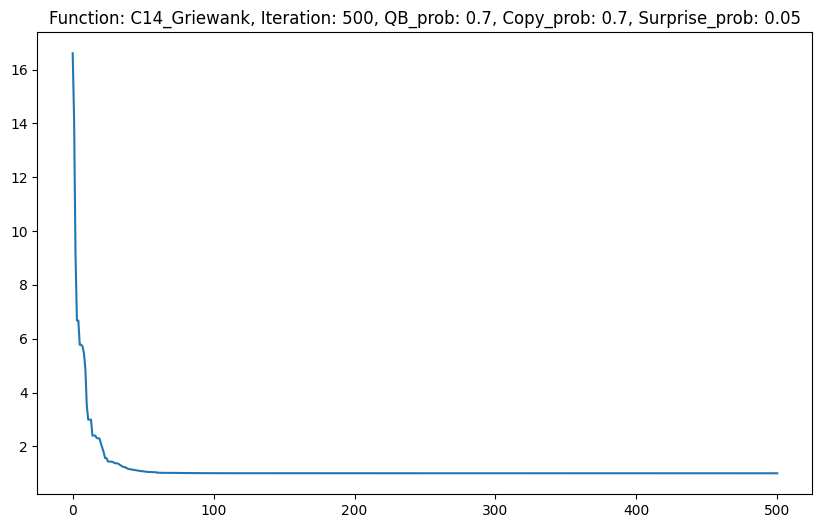

In [28]:
print(f'min: {min(min_sol_value_list)}')
plt.figure(figsize=(10,6))
plt.plot(min_sol_value_list)
# plt.ylim([25,30]) 
plt.title(f'Function: {function_selected}, Iteration: {max_iteration}, QB_prob: {qtb_prob}, Copy_prob: {copy_prob}, Surprise_prob: {surprise_prob}')
plt.show()


# minimum value: {min(min_sol_value_list)}